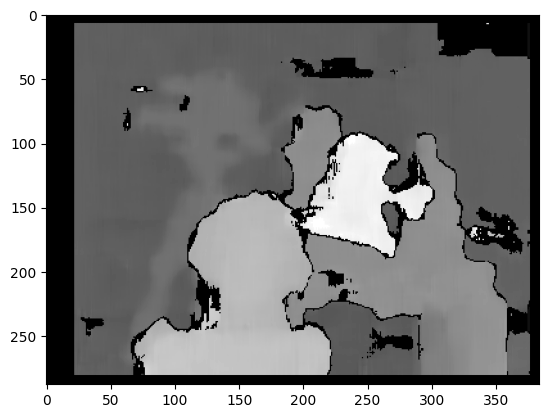

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgL = cv2.imread('./data/tsukuba_l.png',0)
imgR = cv2.imread('./data/tsukuba_r.png',0)
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

Using cache found in /home/kar/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/kar/.cache/torch/hub/intel-isl_MiDaS_master


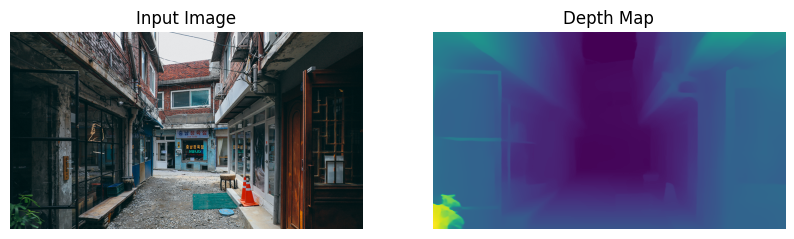

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load MiDaS model
model_type = "DPT_Large"  # Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

# Load MiDaS transform
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform if model_type in ["DPT_Large", "DPT_Hybrid"] else midas_transforms.small_transform

# Load and preprocess the input image
input_image = cv2.imread("test.png")  # Replace with your image path
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

input_batch = transform(input_image).to(device)

# Perform depth estimation
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=input_image.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

# Normalize the depth map for visualization
depth_map = prediction.cpu().numpy()
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(input_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Depth Map")
plt.imshow(depth_map, cmap="inferno")
plt.axis("off")

plt.show()